### Perturbed Harper model and associated quantum system 


In [221]:
import numpy as np

import matplotlib.pyplot as plt
from scipy.integrate import odeint
import mpmath as mpmath

# %matplotlib notebook 
%matplotlib inline 

# for remaking the histograms 

#The histogram figures are 
# Qh01d_2histsa.png 
# Qh01b_larger_2histsb.png


#from scipy.special import erfc
from scipy.linalg import expm
import scipy.special as scipy_special

In [214]:
notebookroot = 'Qh01'  
# for focusing on histograms of quasi energies 
# consider writing a special routine for computing quasienergies of propagator for unperturbed system
# to speed up and check Poisson like stats of quasienergy level diffs 

In [3]:
# routines for classical system integration 

# set up equations of motion
# y = [phi,p]  dimension 2
# H(phi,p,tau) = a(1 - cos (p-b)) - epsilon*cos phi - mu*cos(phi - tau) - mup*cos(phi + tau)
# dy/dt = [\dot phi, \dot p]
#       = [a\sin p, -epsilon*sin(phi) - mu*sin(phi - tau) - mup*sin(phi + tau) ]
#There should be three islands, one at p=0 and the others at sin p=1/a
#the widths of these are set by \sqrt{2 epsilon/a}, \sqrt{2 mu/a},  \sqrt{2 mup/a}

# dy/dtau = func(y,tau), needed for integrator!
# note that y[0] = phi and y[1] = p
def cfunc(y,tau,a,b,epsilon,mu,mup):
        return [a*np.sin(y[1]-b),\
                -epsilon*np.sin(y[0]) - mu*np.sin(y[0] - tau) - mup*np.sin(y[0] + tau)]

# is used for energy values, not currently used anywhere
def H_classical(p,phi,tau,a,b,epsilon,mu,mup):
    #phi = y[0]; p = y[1]
    return a*(1.0 - np.cos(p-b)) - epsilon*np.cos(phi)\
        - mu*np.cos(phi-tau) - mup*np.cos(phi+tau)

# we use this function to compute expectation values and dispersions of unperturbed energies, for classical orbits
def H_classical0(p,phi,tau,a,b,epsilon,mu,mup):
    return a*(1.0 - np.cos(p-b)) - epsilon*np.cos(phi) 
        #- mu*np.cos(phi-tau) - mup*np.cos(phi+tau)

In [4]:
# integrate at a period, the forced pendulum 
# arguments:
#   y0: is initial conditions, 
#   npoints: is number of points we want
#   a,epsilon, mu, mup: are parameters of the Hamiltonian model
#   taushift:  points of output are at times  taushift + 2 pi n, integer n up to npoints 
#
#   integrate every 2 pi period, npoints returned including initial condition 
# returns: phi,p arrays of integrated points 
# this particular routine does all times at once by sending a set of times to the integrator
# if we want to take p modulo 2pi we would have to integrate slowly to find when trajectories
# cross pi or -pi
twopi = 2.0*np.pi
def givepoints_arr(y0,npoints,a,b,epsilon,mu,mup,taushift):
    # set up time array, every 2pi/nu so for period of perturbation
    step  = 2.0*np.pi
    stop = step*npoints
    time  = np.arange(0.0,stop,step)  # time array for outputs  goes from 0 to stop-step 
    #                              with increment step, does not reach stop. 
    time += taushift  # shift time vector 
    # do the integration
    y = odeint(cfunc, y0, time, args=(a,b,epsilon,mu,mup))
    #y2 = odeint(func, y0, time, Dfun=jacobian, args=(epsilon,mu,nu))  # if you want to use a jacobian
    phi_arr = np.squeeze(y[:,0])  # is an array of phi at different times
    p_arr = np.squeeze(y[:,1])    # is an array of momenta at different times
    
    phi_arr  = phi_arr%twopi  # so that phi in [0:2pi]
    p_arr = p_arr%twopi  # so that p is in [0,2pi]
    
    ii = phi_arr >np.pi
    phi_arr[ii]-= twopi # now phi is in [-pi,pi]
    ii = p_arr >np.pi
    p_arr[ii]-= twopi   # now p is in [-pi,pi]
    
    return phi_arr,p_arr 
       
# integrate points and plot them on axis ax   
def givepoints(y0,npoints,a,b,epsilon,mu,mup,taushift,marker,ax):
    phi_arr,p_arr=givepoints_arr(y0,npoints,a,b,epsilon,mu,mup,taushift)
    ax.plot(phi_arr,p_arr,marker,markersize=0.5) # plot it
    
colorlist = ['black','blue','green','magenta','red','orange','gold','blueviolet','springgreen','dodgerblue']

# randomly choose an initial condition, integrate and plot in axis ax 
# arguments:
#    npoints: numbers of points to plot 
#    pmin, pmax constrain the vertical width of randomly chosen initial conditions 
#    a,epsilon,mu,mup,b: parameters for the dynamical model 
#    ax  the axis on which to plot points 
def rand_give_points(npoints,a,b,epsilon,mu,mup,taushift,pmin,pmax,ax):
    phi = np.random.uniform(low=-np.pi,high=np.pi)
    p = np.random.uniform(low=pmin,high=pmax)
    y0 = [phi,p]
    phi_arr,p_arr=givepoints_arr(y0,npoints,a,b,epsilon,mu,mup,taushift)
    i = np.random.randint(low=0,high =len(colorlist))
    ax.scatter(phi_arr,p_arr,s=1,edgecolor='none',facecolor=colorlist[i],lw=1)

# make a surface of section figure with orbits 
# inputs: a classical model class, and a label
def mkfig_cl(cla,alabel):
    norb = cla.norb
    npoints = cla.npoints
    a = cla.a 
    b = cla.b 
    eps = cla.eps
    mu = cla.mu
    mup = cla.mup 
    taushift = cla.taushift
    froot = cla.froot
    
    # set up display
    fig,ax = plt.subplots(1,1,figsize=(3,3),dpi=200) 
    plt.subplots_adjust(bottom=0.18,top=0.90,left=0.18,right=0.98)
    ax.text(2.6,-3.9,r'$\phi$',fontsize=14)
    ax.set_ylabel('p',labelpad=0)
    ax.set_aspect('equal')

    fac=1.01
    xmax = np.pi;  ymax = np.pi;  ymin = -ymax
    ax.set_xlim([-xmax*fac,xmax*fac])
    ax.set_ylim([ ymin*fac,ymax*fac])

    parm_label = r'$a$={:.2f},'.format(a)
    parm_label += r'$\epsilon$={:.2f},'.format(eps)
    parm_label += r'$\mu$={:.2f},'.format(mu)
    muprime = r'$\mu$' + '\''
    parm_label += muprime
    parm_label += r'={:.2f},'.format(mup)
    #parm_label += r'$\nu$={:.0f}'.format(nu)
    ax.text(0,3.4,parm_label,ha='center',va='center')

    for i in range(norb):  # this many orbits , and plots points
        rand_give_points(npoints,a,b,eps,mu,mup,taushift,ymin,ymax,ax)
        
    if (len(alabel)>1):
        plt.text(-4.5,3.2,alabel,fontsize=14)
    if (len(froot)>2):
        ofile = froot + '_class.png'
        plt.savefig(ofile,dpi=300)
        
    plt.show()
     
# a class to store classical model info
#    norb:  numbers of orbits
#    npoints: numbers of points to plot 
#    a,epsilon,mu,mup,b,taushift: parameters for the dynamical model 
#    froot: a root for labeling files 
class Hcla:
    def __init__(self,norb,npoints,a,b,eps,mu,mup,taushift,froot):
        self.a = a
        self.b = b
        self.eps = eps
        self.mu = mu
        self.mup = mup
        self.taushift = taushift
        self.norb = norb
        self.npoints = npoints
        self.froot = froot
        
    # randomly choose an norb initial conditions, integrate and compute <h_0> and sqrt(<h_0^2 - <h_0>^2>)
    #  from the orbits  
    # compute   mu_arr: mean H0 of each orbit
    # compute   sig_arr: standard deviation of H0 for each orbit
    # store this info in the class itself
    def sigh0_orbs(self):
        mu_arr = np.zeros(self.norb)
        sig_arr = np.zeros(self.norb)
        for i in range(self.norb):
            phi = np.random.uniform(low=-np.pi,high=np.pi)
            p = np.random.uniform(low=-np.pi,high=np.pi)
            y0 = [phi,p]
            phi_arr,p_arr=givepoints_arr(y0,self.npoints,self.a,self.b,self.eps,self.mu,self.mup,self.taushift)
            # Elist = H_classical(p_arr,phi_arr,1,self.a,self.b,self.eps,self.mu,self.mup)  #this is wrong 
            # why is there a tau=1 here and why is not mu=0,mup=0 so it is actually h0?
            Elist = H_classical0(p_arr,phi_arr,0,self.a,self.b,self.eps,self.mu,self.mup) # this is correct and what we should use
            # gives values of <H0> and sigma^2 for H0 for classical orbits!  (fixed Feb 2025, but did not affect figures significantly)
            # if <h0> classical look bad, do more orbits or redo to get different random initial conditions for the orbits 
            mu_arr[i] = np.mean(Elist)  # compute means of H0
            sig_arr[i] = np.std(Elist)  # compute standard deviations of H0
            
        iphi = np.argsort(mu_arr) # in order of increasing energy
        self.mu_arr = mu_arr[iphi]
        self.sig_arr = sig_arr[iphi]
        #return mu_arr,sig_arr
    
    def print_info(self):
        # compute resonance half widths 
        wid0 = 2*np.arcsin(np.sqrt(np.abs(self.eps/self.a)))
        widmu = 2*np.arcsin(np.sqrt(np.abs(self.mu/self.a)))
        widmup = 2*np.arcsin(np.sqrt(np.abs(self.mup/self.a)))
        print('res widths {:.2f}, {:.2f}, {:.2f}'.format(wid0,widmu,widmup))
    
        if (self.a<1):
            print('res locs p=0,+-none, a <1')
        else:
            p_mu = np.arcsin(1/self.a)  # a resonance location 
            print('res locs p=0,+-{:.2f}'.format(p_mu))
            overlap1 = p_mu - (wid0+widmu)
            overlap2 = p_mu - (wid0+widmup)
            print('overlaps {:.2f} {:.2f}'.format(overlap1,overlap2)) # guess of overlaps
        
        omega0 = np.sqrt(self.a*self.eps) # frequency of primary resonance 
        print('omega0 = {:.2f}'.format(omega0))
        
        # not sure what this is right now
        deltH = 4*np.pi*self.mu/omega0  * np.exp(-0.5*np.pi/omega0)  # this is the half width about 
        print('deltH = {:.3f}'.format(deltH))
        #range of energy is 2*(eps+a), range of p is 2pi so we guess at 
        Deltp = 2*deltH/(2*self.eps + 2*self.a) *2*np.pi # change in p is
        print('Deltp = {:.3f}'.format(Deltp))

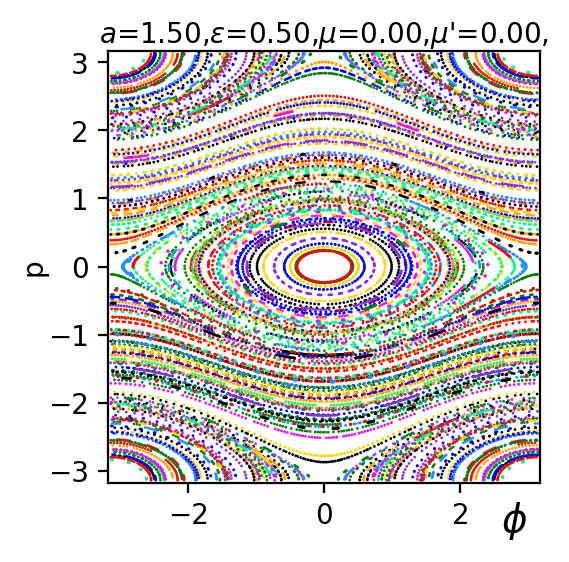

In [200]:
# choose parameters
a=1.5;  b=0; taushift = 0 
eps=0.5
mu=0.0; mup=mu
npoints=100 # points in each orbit!
norb = 200  # number of orbits
froot = notebookroot+'b_vanil'
froot = ''
cla_Q9b_vanil = Hcla(norb,npoints,a,b,eps,mu,mup,taushift,froot)
mkfig_cl(cla_Q9b_vanil,'')
#cla_Q9b_vanil.print_info()
#cla_Q9b_vanil.sigh0_orbs()

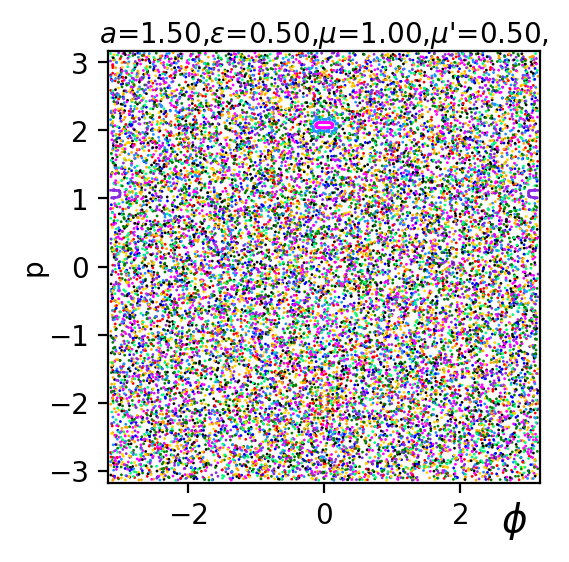

In [199]:
# choose parameters
a=1.5;  b=0; taushift = 0 
eps=0.5
mu=1.; mup=0.5
npoints=100 # points in each orbit!
norb = 200  # number of orbits
froot = notebookroot+'c_vanil'
froot = ''
cla_Q9c = Hcla(norb,npoints,a,b,eps,mu,mup,taushift,froot)
mkfig_cl(cla_Q9c,'')


In [10]:
# routines for displacement operator, coherent states and Husimi distribution 

# return Xhat as a 2d NxN complex matrix (unitary)   
def Xhat_op(N): # in regular basis 
    X = np.zeros((N,N),dtype=complex)
    for k in range(N):
        X[(k+1)%N,k] = 1.0 + 0j
    return X

# return Zhat as a 2d NxN complex matrix (unitary)  
def Zhat_op(N):  # in regular basis
    Z = np.zeros((N,N),dtype=complex)
    for k in range(N):
        omegaj = np.exp(2*np.pi*k*1j/N)
        Z[k,k] = omegaj 
    return Z

# adjoint of Zhat
def Zhat_dagger_op(N):
    return np.conjugate(Zhat_op(N))

# adjoint of Xhat
def Xhat_dagger_op(N):
    return np.transpose(Xhat_op(N))

# additional discrete ops
def cos_phi_op(N):
    return (Zhat_op(N) + Zhat_dagger_op(N))*0.5

def sin_phi_op(N):
    return (Zhat_op(N) - Zhat_dagger_op(N))/(2.0j)

def cos_p_op(N):
    return (Xhat_op(N) + Xhat_dagger_op(N))*0.5

def sin_p_op(N):
    return (Xhat_op(N) - Xhat_dagger_op(N))/(2.0j)

# create Dhat, the displacement operator as a function of k,l  
# returns an NxN complex matrix, is unitary 
# computes omega^-kl/2  X^l Z^k
def Displacement_op(N,k,l):
    #D = np.zeros((N,N),dtype=complex)
    omega = np.exp(2*np.pi*1j/N)
    #omfac = np.power(-omega*k*l/2.0)
    X = Xhat_op(N)
    Z = Zhat_op(N)
    Xl = np.linalg.matrix_power(X, l)
    Zk = np.linalg.matrix_power(Z, k)
    Dhat= np.power(omega,-k*l/2.0) * np.matmul(Zk,Xl)
    return Dhat

# computes eigenfunction |\tilde eta> of the QFT 
# returns an N dimensional complex normalized statevector 
# This is a unimodal periodic thing which is peaked at index 0
def eta_tilde(N):
    eta = np.zeros(N,dtype=complex)
    efac = np.exp(-np.pi/N)
    for m in range(N):  # compute using theta function 
        eta[m] = np.real(mpmath.jtheta(3,np.pi*m/N,efac)/np.sqrt(N))
    eta_mag = np.sqrt(np.sum(eta*np.conj(eta)))
    eta = eta/eta_mag   # normalize
    return eta

#  Creat a coherent state from Displacement operator hat D and eigenfunction |tilde eta>
# returns an N dimensional complex normalized state vector 
def coherent_state(N,k,l):
    Dhat = Displacement_op(N,k,l)
    eta=eta_tilde(N)
    ch = np.matmul(Dhat,eta)
    return ch

# make a set of coherent states from QFT eigenfunction |tilde eta> and displacement op
# returns an N x N x N 3D complex array 
#   the matrix [k,l,:] is the coherent state |k,l>
#  a more efficient version 
def coh_Dkl_b(N):
    c_matrix = np.zeros((N,N,N),dtype=complex)
    eta=eta_tilde(N)  #only do this once
    omega = np.exp(2*np.pi*1j/N)  #only do this once
    #omfac = np.power(-omega*k*l/2.0)
    X = Xhat_op(N) # only do this once
    Z = Zhat_op(N) # only do this once
    Zk = np.linalg.matrix_power(Z, 0) # equivalent to identity 
    for k in range(N):
        Xl = np.linalg.matrix_power(X, 0) # equivalent to identity 
        for l in range(N):
            #Xl = np.linalg.matrix_power(X, l)
            Dhat = np.power(omega,-k*l/2.0) * np.matmul(Zk,Xl)
            #Dhat = Displacement_op(N,k,l)
            c_matrix[k,l,:] = np.matmul(Dhat,eta)  
            # if displacement is in p direction then p increases with l
            # and k increases in x direction 
            # note that imshow displays arrays with [j,k] with j in y direction
            Xl = np.matmul(X,Xl)
        Zk = np.matmul(Z,Zk)
    return c_matrix
   
# compute Hussimi distribution of an N dimensional state vector psi 
# in advance you have computed a set of coherent states with above
#    routine coh_Dkl_b(N) 
# the set of coherent states is given via the argument c_matrix 
#    c_matrix should be an NxNxN matrix 
# the routine returns an NxN real matrix which is the Hussimi function  
#   note that index order is p,x  so that y would be first index, as expected for plotting with imshow
def Husimi(psi,c_matrix):
    N = len(psi)
    H_matrix = np.zeros((N,N))
    cshape = c_matrix.shape
    if (cshape[0] != N):
        print('c_matrix is wrong dimension')
    for k in range(N):
        for l in range(N):
            co_kl = np.squeeze(c_matrix[k,l,:])  #coherent state |k,l> -p,x
            mag = np.vdot(psi,co_kl) # dot product
            mag = np.absolute(mag) # is real 
            H_matrix[k,l] = mag**2  

    return H_matrix

In [11]:
# routines for showing eigenvalues of a unitary operator 
# also for computing the QFT and its inverse  

# arguments: w an array of complex eigenvalues, assumed roots of unity
# sorts the phases
# returns: an array of normalized differences between the phases of the eigenvalues 
twopi = np.pi*2
def compute_s(w):
    phi_arr = np.angle(w) # get the phase angles in [-pi,pi] of complex numbers
    # this ignores magnitude of w if it is not on the unit circle 
    phi_arr_sort = np.sort(phi_arr)  # put in order of increasing phase
    phi_shift = np.roll(np.copy(phi_arr_sort),1)
    dphi = (phi_arr_sort - phi_shift + np.pi)%twopi - np.pi  # takes care of 2pi shift
    mu_dphi = np.mean(dphi)  # find mean value of dphi 
    sarr = dphi/mu_dphi  # this is s /<s>
    return sarr  # returns normalized phase differences 

# sort eigenvalues and eigenvectors in order of increasing phase
# eigenvectors from np.linalg.eig are in form vr[:,j]
def esort_phase(w,vr):
    phi_arr = np.angle(w) # get the phase angles in [-pi,pi] of complex numbers
    iphi = np.argsort(phi_arr) # in order of increasing phase
    wsort = w[iphi]
    vrsort = np.copy(vr)*0.0
    for i in range(len(w)):
        vrsort[:,i] = vr[:,iphi[i]]
    #vrsort = vr[:,iphi]  # does this work? I think so! yes
    return wsort,vrsort

# create a probability vector for the i-th eigenvector 
# vr is an array of eigenvectors 
def get_probs(vr,i):
    v = vr[:,i]
    probi = np.real(v*np.conjugate(v)) # probability vector 
    return probi  # should be n dimensional real vector 

# fill matrices with Discrete Fourier transform, returns 2 nxn matrices
# both Q_FT and Q_FT^dagger which is the inverse 
def QFT(n):
    omega = np.exp(2*np.pi*1j/n)
    Q        = np.zeros((n,n),dtype=complex)  # QFT
    Q_dagger = np.zeros((n,n),dtype=complex) 
    for j in range(n):
        for k in range(n):
            Q[j,k] = np.power(omega,j*k)  # not 100% sure about sign here! 
            Q_dagger[j,k] = np.power(omega,-j*k)
    Q        /= np.sqrt(n)  #normalize
    Q_dagger /= np.sqrt(n)
    return Q,Q_dagger 


# plot both eigenvalues on unit circle and histogram of normalized differences between phases of eigenvalues
# and angles in a third plot
def mk_plots_circ(w,froot):
    Re_part = np.real(w)
    Im_part = np.imag(w)
    sarr = compute_s(w)
    angs = np.angle(w)
    
    fig = plt.figure(figsize=(6,2.5),dpi=160)
    plt.subplots_adjust(bottom=0.15,top=0.96,right=0.99,left=0.15,wspace=0.3,hspace=0.2)

    ax_ih=fig.add_axes([0.1,0.15,0.37,0.79])    # histogram
    N = len(Re_part)
    if (N <120):
        nbins = int(N/3)
    else: 
        nbins = 40
    junk = ax_ih.hist(sarr,bins=nbins,range=[0,4])
    ax_ih.set_xlabel(r'$s/\langle s\rangle$',labelpad=0)
    ax_ih.set_ylabel('quasi-energy distribution',labelpad=1)

    iq = 1
    ax_iq=fig.add_axes([0.55,0.15,0.37,0.79])
    junk = ax_iq.plot(angs,'g.',ms=1)
    ax_iq.set_yticks([-np.pi, 0,np.pi], labels=[r'-$\pi$','0',r'$\pi$']) 
    ax_iq.set_ylabel('quasi energy',labelpad=1)
    ax_iq.set_xlabel('index',labelpad=0)

    ax_ic=fig.add_axes([0.68,0.19,0.32,0.32])  
    ax_ic.set_aspect('equal')
    ax_ic.plot(Re_part,Im_part,'k.',ms=1)
    ax_ic.set_xticks([])
    ax_ic.set_yticks([])
    
    if (len(froot)>2):
        # make a) b) labels here!
        ax_ih.text(-0.21,0.98,'c)',transform=ax_ih.transAxes,fontsize=18)
        ax_iq.text(-0.2,0.98,'d)',transform=ax_iq.transAxes,fontsize=18)
        ofile = froot + '_circ.png'
        plt.savefig(ofile,dpi=200)
        
    plt.show()

#sim1.circ(froot); plt.show()

In [12]:
# compute the expectation value of operator, using a state vector evec 
def exp_val(evec,op):
    zvec = np.matmul(op,evec)   # compute op|evec>
    w = np.vdot(evec,zvec)   # complex dot product, evec is conjugated prior to doing the dot product 
    return w 


# sort a set of eigenvalues and eigenfunctions according to the expectation value of an operator
# returns sorted lists and the expectation values and dispersions
# arguments:
#  w is list of eigenvals
#  vr is list of eigenvectors
#  op is operator that you want to use to sort the eigenvec vecs 
# returns:
#   wsort: list of eigenvalues but these are in order of expectation value of operator <op>
#     computed with the eigenvecs  
#   vrsort: list of eigenvecs but in order of <op>
#   expsort: the expectation values <op> in order of increasing value
#   sigsort: the dispersion values (not standard deviations)
def esort_op(w,vr,op):
    n = len(w)
    exp_arr = np.zeros(n,dtype=complex) # to store the expectation values  <op>
    sig_arr = np.zeros(n,dtype=complex) # to store <op^2> - <op>^2
    for i in range(n):
        mu =  exp_val(np.squeeze(vr[:,i]), op)  #h
        mu2 = exp_val(np.squeeze(vr[:,i]), np.matmul(op,op)) #h^2
        sig2 = mu2-mu*mu # compute dispersion too 
        exp_arr[i] = mu
        sig_arr[i] = sig2  # notice is dispersion not std
        # compute the expectation values of the operator for every eigenfunction 
    iphi = np.argsort(np.real(exp_arr)) # sort in order of increasing expectation value 
    wsort = w[iphi]  # sort the eigenvalues 
    expsort = exp_arr[iphi] # sort the expectation values 
    sigsort = sig_arr[iphi] # sort the dispersions 
    vrsort = np.copy(vr)*0.0 # to store the eigenfunctions in order of expectation vals
    for i in range(len(w)):
        vrsort[:,i] = vr[:,iphi[i]]  # sort the eigenfunctions which are vr[:,j]

    return wsort,vrsort,expsort,sigsort

# $\hat h_0 = a(1 - cos \hat p) - \epsilon \cos \hat \phi$
# computes the operator hat h_0, unperturbed hamiltonian 
# much better routine 
def hat_h_0_new(N,a,eps):
    return a*(np.identity(N) - cos_p_op(N)) - eps*cos_phi_op(N)

In [158]:

# compute the propagator U across tau =0 to 2 pi
# trying a somewhat more efficient way to do this!
#  arguments:
#     N      : size of discrete quantum space 
#     ntau   : how many Trotterized steps to take 
#     a,b,eps,mu,mup,taushift      : parameters of classical model, all unitless 
#  returns:  
#    Ufinal  : The propagator hat U_T  (NxN complex matrix)
#    w       : vector of eigenvalues of U in order of increasing phase
#    vr      : vector of associated eigenfunctions of U 
#        vr[:,j] is the eigenvector with eigenvalue w[j]
# note we have shifted indexing so that phi=0, p=0 is in the center of the 2d arrays
shift_by_pi = 0  # for shifting by pi
def U_prop2(N,ntau,a,b,eps,mu,mup,taushift):
    DLambda_A =np.zeros((N,N),dtype=complex)  # storing diagonal matrix for momentum part
    DLambda_Ah =np.zeros((N,N),dtype=complex)  # storing diagonal matrix for momentum part
    DLambda_Ahm =np.zeros((N,N),dtype=complex)  # storing diagonal matrix for momentum part
    DLambda_B =np.zeros((N,N),dtype=complex)  # storing diagonal matrix for phi part
    U_final  =np.zeros((N,N),dtype=complex)  # final propagator
    #Efac = N**2/(4.0*np.pi*ntau)    # includes dtau , is wrong
    Efac = N/ntau    # Bohr Sommerfeld type quantization gives this
    # this is L_0/hbar x 2pi/ntau = N/2pi x 2pi/ntau = N/ntau, is correct , includes dtau
    
    dtau = 2*np.pi/ntau  # step size 
    Q_FT,Q_FT_dagger = QFT(N)  # need only be computed once
    for k in range(N):  #compute ahead of time, fill diagonals
        pk = 2*np.pi*k/N - shift_by_pi  # if you want to shift so 0,0 in center of arrays
        DLambda_Ah[k,k] = np.exp(-0.5j*Efac*a*(1.0 - np.cos(pk-b))) #diagonal in Fourier basis
        DLambda_A[k,k]  = np.exp(  -1j*Efac*a*(1.0 - np.cos(pk-b))) 
        DLambda_Ahm[k,k]= np.exp( 0.5j*Efac*a*(1.0 - np.cos(pk-b))) 
        # these are half step and full step for the momentum part
        
    LAh     = np.matmul(Q_FT,np.matmul(DLambda_Ah ,Q_FT_dagger))  # transfer basis 
    LA      = np.matmul(Q_FT,np.matmul(DLambda_A  ,Q_FT_dagger))   
    LAh_inv = np.matmul(Q_FT,np.matmul(DLambda_Ahm,Q_FT_dagger))
    
    U_final = LAh;  #inverse half step at the beginning 
        
    for i in range(ntau): # each dtau
        tau = i*dtau + taushift # time of propagator shifted by taushift
        for j in range(N):
            phi = 2*np.pi*j/N - shift_by_pi  # if you want to shift so 0,0 in center of arrays 
            DLambda_B[j,j] = np.exp(1j*Efac*(\
                eps*np.cos(phi)+mu*np.cos(phi-tau)+mup*np.cos(phi+tau) )) # create diagonal matrix 
            # note sign of 1j (-1 * -1 = 1)
        U_final = np.matmul(LA,np.matmul(DLambda_B,U_final))
        
    U_final = np.matmul(LAh_inv,U_final)
    
    (w,vr)=np.linalg.eig(U_final)  # get eigenvalues and eigenvectors
    w_s,vr_s = esort_phase(w,vr)   # sort in order of increasing eigenvalue phase
    return w_s,vr_s,U_final 
            
# compute the propagator if not time dependent!
def Uprop_h0(N,a,b,eps):
    hath0 = hat_h_0_new(N,a,eps)  # compute time independent hamiltonian op
    A = hath0*-1j*N   # integrate h0 by 2pi and multiply by -iN/2pi
    U_final = expm(A)  #use scipy.linalg.expm routine for matrix exponentials
    (w,vr)=np.linalg.eig(U_final)  # get eigenvalues and eigenvectors
    w_s,vr_s = esort_phase(w,vr)   # sort in order of increasing eigenvalue phase
    return  w_s,vr_s,U_final 

In [12]:
# compute coherent states in advance
#c_matrix_100 = coh_Dkl_b(100)  # 

In [13]:
#c_matrix_255 = coh_Dkl_b(255)  # takes a while

In [14]:
# compute and store Husimi distributions for all eigenfunctions in an nxnxn array
# arguments:
#    vr eigenvectors  (nxn) matrix but eigenvectors are [:,j]
#    c_matrix nxn matrix of coherent states, precomputed with Dkl_b(n)
# returns matrix of Husimi distributions
def stor_Hus(vr,c_matrix):
    vshape = vr.shape; cshape = c_matrix.shape
    n =vshape[0] 
    if (cshape[0]  != n):
        print('c_matrix wrong size')
        return 0
    Hmatrix_big = np.zeros((n,n,n))  # allocate memory
    for k in range(n):   # loop over eigenstates 
        Hmatrix_big[:,:,k]= Husimi(np.squeeze(vr[:,k]),c_matrix)
    return Hmatrix_big

# show Husimi functions for all eigenfunctions
# arguments:
#  Hmatrix_big: matrix of husimi functions, precomputed
import matplotlib.ticker as mticker
def show_Hus(Hmatrix_big,froot,pcolorbar):
    if (hasattr(Hmatrix_big, "__len__") == False):
        exit
    hshape = Hmatrix_big.shape;
    n =hshape[0]
    sn = int(np.sqrt(n))
    if (n - sn*sn>0):
        sn+=1;   #increase number of square so that all states are displayed

    fig,axarr = plt.subplots(sn,sn,figsize=(5.1,5.0),sharex=True,sharey=True,dpi=200)
    plt.subplots_adjust(hspace=0,wspace=0,left=0.08,right=1.0,top=0.95,bottom=0.0);
    axarr[0,0].set_xticks([])
    axarr[0,0].set_yticks([])
    zmax = 1/sn  # could be adjusted!!!! or an argument
    
    ax=fig.add_axes([0,0,1,1],frame_on = False) 
    ax.set_xticks([])
    ax.set_yticks([])
    if (n < 200):
        ax.text(0.00,0.94,'b)',transform=ax.transAxes,fontsize=26)
    
    for i in range(sn):
        for j in range(sn): 
            axarr[i,j].set_aspect('equal')
    nhalf = (int)(n/2)
    
    for i in range(sn):   # plots are in y direction from top to down
        for j in range(sn):  # plots in x direction from left to right
            k = i*sn + j  # incrementing horizontally first
            if (k < n):
                Hmatrix_k = np.squeeze(Hmatrix_big[:,:,k])
                Hmatrix_b = np.roll(Hmatrix_k, nhalf, axis=0) # shift 0,0 to center of image 
                Hmatrix = np.roll(Hmatrix_b, nhalf, axis=1)
                im=axarr[i,j].imshow(Hmatrix,origin='lower',vmin=0,\
                                     vmax=zmax,cmap='terrain') # flips y direction of display
                #im=axarr[i,j].imshow(Hmatrix,vmin=0,vmax=zmax,cmap='terrain')
                if (k==0):
                    im0 = im
    
    if (pcolorbar==True):
        cax=fig.add_axes([0.055,0.03,0.02,0.5])
        cbar = plt.colorbar(im0,cax=cax,ticks = [0,zmax],location='left',format=mticker.FixedFormatter(['0', '']))   
        ccc = '{:.3e}'.format(zmax)
        cax.text(0.5,zmax*1.02,ccc,fontsize=8,rotation='vertical',va='bottom',ha='center')

    #axarr[0,0].plot([0],[0],'ro')
    
    if (len(froot)>2):
        ofile = froot + '_Hus.png'
        plt.savefig(ofile,dpi=200)
    plt.show()   


#sim2v.Hus(True) # show husimi function of eigenvecs 
#sim4.Hus(True) # show husimi function of eigenvecs 

In [248]:
# class structure to store a specific dynamical system 
# requires c_matrix, storing coherent states to be made ahead of time
class Hsys:
    def __init__(self,n,ntau,a,b,eps,mu,mup,taushift,c_matrix,froot):
        self.n = n
        self.ntau = ntau
        self.a = a
        self.b = b
        self.eps = eps
        self.mu = mu
        self.mup = mup
        self.taushift = taushift
        self.froot = froot
        norb  = 100; npoints =200
        self.cla = Hcla(norb,npoints,a,b,eps,mu,mup,taushift,froot) # make a classical class 
        # compute the propagator and eigenfunctions and eigenvalues
        if ((mu!=0) or (mup!=0)):
            w,vr,Up= U_prop2(n,ntau,a,b,eps,mu,mup,taushift) # is sorted according in order of phase 
        else:
            w,vr,Up= Uprop_h0(n,a,b,eps)
        self.w = w   # quasi-eigenvalues  (order of phase)
        self.vr = vr  # eigenvectors (order of phase)
        self.Up = Up   # unitary transformation 
        self.c_matrix = c_matrix   # matrix of coherent states
        # compute Husimi distribution
        #self.Hmatrix_big = stor_Hus(self.vr,self.c_matrix)
        # compute the operator hat h_0
        self.H0 = hat_h_0_new(self.n,self.a,self.eps)  # store unperturbed hamiltonian op hat h_0
        wsort2,vrsort2,expsort,sigsort = esort_op(self.w,self.vr,self.H0)  # sort in order of expectation of H0
        self.w2 = wsort2
        self.vr2 = vrsort2 
        self.exp_H0 = expsort   # store <H_0>, order low to high 
        self.exp_sig_H0 = sigsort  # shore <H_0^2> - <H_0>^2 for each eigenvector, these are ^2
        # compute the Husimi functions, only if there is a good c_matrix 
        if hasattr(c_matrix, "__len__"):
            if (len(c_matrix.shape)==3):
                self.Hmatrix_big2 = stor_Hus(self.vr2,self.c_matrix)  # compute Husimi functions for each eigenfunction 
        
    def Hus(self,pcolorbar):   # show Husimi distribution, with colorbar if pcolorbar = True
        #show_Hus(self.Hmatrix_big,froot)  
        # increasing in order from left to right in each row and then rows top to bottom 
        # this version is in order of expectation of H_0
        show_Hus(self.Hmatrix_big2,self.froot,pcolorbar) 
            
    def circ(self):  # show stuff about eigenvalues 
        mk_plots_circ(self.w,self.froot) 
        
    def classical(self,norb,npoints):  # show classical phase space of associated classical model
        self.cla.norb=norb
        self.cla.npoints=npoints
        mkfig_cl(cla,'a)')

    # you need to run the points before calling this to show the h0 and stds of h0 for both quantum and classical
    # first do these: 
    # sim.cla.norbs=500
    # sim.cla.npoints=400
    # sim.cla.sigh0_orbs() # run orbits 
    def plt_H0(self,xlabel):
        mkfig_H0b(self.exp_H0,self.exp_sig_H0,self.cla.mu_arr,self.cla.sig_arr,self.froot,xlabel)
        #mkfig_H0(self.exp_H0,self.exp_sig_H0,self.froot,xlabel)

    def plt_H0_corr(self):
        mkfig_H0_corr(self.exp_H0,self.exp_sig_H0,self.froot)

# show both <h0> and standard deviation for both quantum and classical in a plot
def mkfig_H0b(qexps,qsigs,cexps,csigs,froot,xlabel):
    fig,axarr = plt.subplots(2,1,figsize=(3.2,2.9),dpi=260,sharex=True)
    plt.subplots_adjust(left=0.25,bottom=0.15,right=0.98,top=0.96,wspace=0,hspace=0)
    
    n = len(qexps)
    indexs = np.arange(n)
    fin = np.linspace(0,n,len(cexps))
    
    # classical 
    axarr[0].plot(fin,cexps,'s',color='blue',ms=1,label='Classical',markerfacecolor='None',\
                  markeredgewidth=1,alpha=0.7)
    axarr[1].plot(fin,csigs,'s',color='blue',ms=1,markerfacecolor='None',markeredgewidth=1,\
                 alpha=0.7)
    
    cmax = np.max(csigs)
    if (cmax < 0.01):
        axarr[1].set_ylim([-0.001,0.012])
    
    # quantum 
    axarr[0].plot(indexs,np.real(qexps),'o',ms=2.0,label='Quantum',color='brown',alpha=0.7)
    axarr[1].plot(indexs,np.sqrt(np.real(qsigs)),'o',ms=2.0,color='brown',alpha=0.7)
    
    axarr[0].set_ylabel(r'$\mu_{h0,j}$') 
    axarr[1].set_ylabel(r'$\sigma_{h0,j}$',labelpad=0)  
    axarr[1].set_xlabel('index j')
    
    axarr[0].legend(borderpad=0.2,handlelength=1,labelspacing=0.3,handletextpad=0.2)
    
    if (len(froot)>2):
        if (len(xlabel)>1):
            axarr[0].text(-0.25,0.94,xlabel,transform=axarr[0].transAxes,fontsize=18)
        ofile = froot + '_H0.png'
        plt.savefig(ofile,dpi=200)
    plt.show()
    
#sim2.cla.norbs=500
#sim2.cla.npoints=400
#sim2.cla.sigh0_orbs()
#mkfig_H0b(sim2.exp_H0,sim2.exp_sig_H0,sim2.cla.mu_arr,sim2.cla.sig_arr,sim2.froot)
        
# show both <h0> and standard deviation in a plot
def mkfig_H0(exps,sigs,froot,xlabel):
    fig,axarr = plt.subplots(2,1,figsize=(3.2,2.9),dpi=260,sharex=True)
    plt.subplots_adjust(left=0.23,bottom=0.15,right=0.98,top=0.96,wspace=0,hspace=0)
    axarr[0].plot(np.real(exps),'b.',ms=1)
    axarr[1].plot(np.sqrt(np.real(sigs)),'g.',ms=1)
    axarr[0].set_ylabel(r'$\mu_{h0,j}$') 
    axarr[1].set_ylabel(r'$\sigma_{h0,j}$',labelpad=0)  
    axarr[1].set_xlabel('index')
            
    if (len(froot)>2):
        if (len(xlabel)>1):
            axarr[0].text(-0.25,0.94,xlabel,transform=axarr[0].transAxes,fontsize=18)
        ofile = froot + '_H0.png'
        plt.savefig(ofile,dpi=200)
    plt.show()
        
#sim1.plt_H0(froot); plt.show()   

def mkfig_H0_corr(exps,sigs,froot):
    fig,ax = plt.subplots(1,1,figsize=(3,2.5),dpi=170)
    plt.subplots_adjust(left=0.23,bottom=0.2,right=0.98,wspace=0,hspace=0)
    ax.plot(np.real(exps),np.sqrt(np.real(sigs)),'k.',ms=1)
    ax.set_xlabel(r'$\langle \hat h_0\rangle$') 
    ax.set_ylabel(r'$\sqrt{\langle \hat h_0^2 \rangle - \langle \hat h_0 \rangle^2}$')  

    if (len(froot)>2):
        ofile = froot + '_H0corr.png'
        plt.savefig(ofile,dpi=200)
    plt.show()
    

# probability distributions for energy spacings
#  all are normalized and have mean of 1
def ps_GUE(s):
    z = (32./np.pi**2)*s**2 * np.exp(-4.0*s**2/np.pi)  # gaussian unitary ensemble
    return z 

def ps_GOE(s):
    z = (np.pi/2.) * s * np.exp( -np.pi*s*s/4.)  # gaussian orthogonal ensemble
    return z 

# Poisson
def ps_POI(s):
    return np.exp(-s)

# needed for Berry Robnik distributions, eqn 33 in their paper 
# M V Berry and M Robnik 1984 J. Phys. A: Math. Gen. 17 2413 on semi-classical level spacings
# rho_1 is average density for the classical component
# N_C is the number of chaotic components and assumed that they have equal rho's
# rho is the mean energy level spacing 
#needs this: scipy.special.erfc
def ps_Berry_Robnik_eqn33(S,rho_1,N_C):
    fac1 = np.exp(-rho_1*S)
    rhobar = (1.0-rho_1)/(N_C-1.0)
    er_term = scipy_special.erfc((np.sqrt(np.pi)/2)*rhobar*S)  # calls this scipy.special.erfc = (1 - erf)
    ex_term = np.exp(-np.pi*np.power(rhobar*S/2,2))
    fac2 = np.power(er_term,N_C-3)
    fac3 = rho_1**2 * er_term**2 + (N_C-1)*er_term*ex_term*(2*rho_1*rhobar + np.pi*rhobar**3*S/2)
    fac3 += (N_C-1)*(N_C-2)* rhobar**2 * ex_term
    return fac1*fac2*fac3

# this has been checked, looks okay, though I am not 100% sure about normalization 

def ps_Berry_Robnik_P2(S,rho_1):  # this is equation 28 by Berry and Robnik
    fac1 = np.exp(-rho_1*S)
    rhobar = (1.0-rho_1)
    er_term = scipy_special.erfc((np.sqrt(np.pi)/2)*rhobar*S)  # calls this scipy.special.erfc = (1 - erf)
    ex_term = np.exp(-np.pi*np.power(rhobar*S/2,2))
    term1 = rho_1**2 * fac1 * er_term 
    term2 = (2*rho_1*rhobar  + (np.pi/2)*rhobar**3*S) * ex_term *fac1
    return term1+term2 

def ps_Brody(S,beta):
    z = scipy_special.gamma((beta+2.)/(beta+1))
    C_2 = np.power( z, beta+1)
    C_1 = (beta+1.)*C_2
    return C_1 * S**beta *np.exp(-C_2*S**(beta+1))
    


In [243]:
# compare three energy level differences distributions, separated at a level for <h_0^2 - mu_h^2> 
# not actually doing three here, just 2 because plot was too cluttered 
def comp_2histsa(sim1,sim3,N_C,rho_1):
    # create the normalized difference distributions 
    sarr1 = compute_s(sim1.w2)  # 
    #sarr2 = compute_s(sim2.w2)
    sarr3 = compute_s(sim3.w2)
    
    fig,ax = plt.subplots(1,1,figsize=(3.2,2.5),dpi=250)
    plt.subplots_adjust(bottom=0.15,top=0.93,right=0.99,left=0.18,wspace=0.3,hspace=0.2)

    #N = len(sarr1)
    nbins = 20
    style1 = {'facecolor': 'darkorange', 'edgecolor': 'red', 'linewidth': 1}
    #style2 = {'facecolor': 'red', 'edgecolor': 'red', 'linewidth': 1}
    style3 = {'facecolor': 'blue', 'edgecolor': 'purple', 'linewidth': 3, 'linestyle':'solid','hatch': '//'}
    
    #string1 = 'vanil'
    #string2 = 'a'
    #string3 = 'b'
    
    muprime = r'$\mu$' + '\''
    
    parm_label1 = r'$a$={:.1f},'.format(sim1.a)
    parm_label1 += r'$\epsilon$={:.1f},'.format(sim1.eps)
    parm_label1 += r'$\mu$='
    #parm_label += '\n'
    if (sim1.mu == sim1.mup):
        parm_label1 += muprime
        parm_label1 += r'={:.1f}'.format(sim1.mu)
    else:
        parm_label1 += r'{:.1f}'.format(sim1.mu)
        parm_label1 += ','
        parm_label1 += muprime
        parm_label1 += r'={:.1f}'.format(sim1.mup)
        
    parm_label3 = r'$a$={:.1f},'.format(sim3.a)
    parm_label3 += r'$\epsilon$={:.1f},'.format(sim3.eps)
    parm_label3 += r'$\mu$={:.1f},'.format(sim3.mu)
    parm_label3 += muprime
    parm_label3 += r'={:.1f}'.format(sim3.mup)
    
    
    bbins = np.linspace(0.0,4,25)
    #bbins = np.append(0, bbins)
    junk1 = ax.hist(sarr1,bins=bbins,alpha=0.3,**style1,density=True,label=parm_label1,histtype='stepfilled')
    #junk2 = ax.hist(sarr2,bins=23,range=[0,4],alpha=0.3,**style2,density=True,label=string2,histtype='step',hatch='/')
    junk3 = ax.hist(sarr3,bins=bbins,range=[0,4],alpha=0.6,**style3,density=True,label=parm_label3,histtype='step')
    
    ax.set_xlabel(r'$s/\langle s\rangle$',labelpad=0)
    ax.set_ylabel('quasi-energy distribution',labelpad=1)
    nstring = r'N={:d}'.format(sim1.n)
    ax.text(3,0.3,nstring)

    # create some model distributions 
    slin = np.linspace(0, 4.1, 100)
    g_E = ps_GUE(slin)
    g_O = ps_GOE(slin)
    g_P = ps_POI(slin)
    ax.plot(slin,g_P,':',lw=0.7,label='Poisson',color='firebrick')
    #ax.plot(slin,g_E,'k--',lw=0.7,label='GUE',alpha=0.7)
    ax.plot(slin,g_O,'k--',lw=0.5,label='GOE')

    if (rho_1 >0):
        #N_C = 3; 
        if (N_C >2):
            g_BR = ps_Berry_Robnik_eqn33(slin,rho_1,N_C)  # Berry Rodnik curves 
        else:
             g_BR = ps_Berry_Robnik_P2(slin,rho_1)
        BR_string = 'BerrRod ' + r'$\rho_1$' + '={:.2f}'.format(rho_1) + r',$N_C$={:d}'.format(int(N_C))
        ax.plot(slin,g_BR,'-.',lw=1.5,label=BR_string,color='violet')

    plt.legend(borderpad=0.5,handlelength=1,labelspacing=0.2,handletextpad=0.5,fontsize=8)

    if (True):
        # make labels here
        ax.text(-0.22,0.98,'a)',transform=ax.transAxes,fontsize=18)
        ofile = sim1.froot + '_2histsa.png'
        plt.savefig(ofile,dpi=200)
        print(ofile)
        
    plt.show()
        


In [196]:
n=999; ntau=5*n;  a = 1.5; eps = 0.5; mu = 1.; mup=0.5; b=0.0; taushift=0.0
# class computes propagator and Husimi distn
junk_array = np.zeros(0)
froot = notebookroot+'d'
sim5 = Hsys(n,ntau,a,b,eps,mu,mup,taushift,junk_array,froot)
# this takes a while!!!!!! and is very chaotic 

ntau=1;  #a = 0.5; eps = a;  # ntau is not used if mu= mup=0
mu = 0.; mup=mu; b=0.0; taushift=0.0
# class computes propagator and Husimi distn
junk_array = np.zeros(0)
froot = notebookroot+'c'
sim6 = Hsys(n,ntau,a,b,eps,mu,mup,taushift,junk_array,froot)  # associated non chaotic model 


Qh01d_2histsa.png


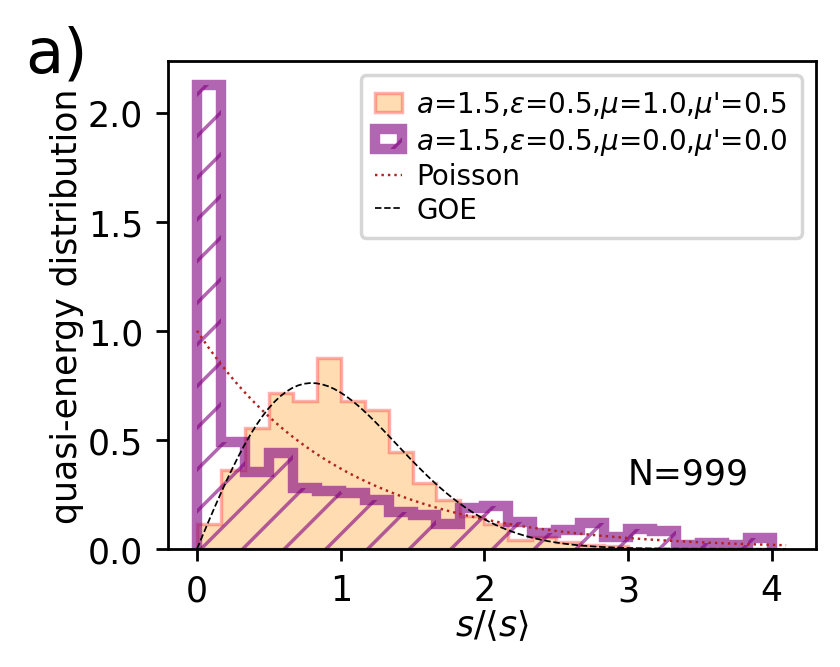

In [244]:
#rho_1 = 0.2; N_C = 3
rho_1 = -0.01; N_C = 3
comp_2histsa(sim5,sim6,N_C,rho_1)  # make  figure!
# this is not the same  figure we had in the draft!
# BR does not look correctly normalized 

In [113]:
# we need a lot of states to look at quasi energy distributions!
# this is the mixed/hybrid system
n=999; ntau=5*n;  a = 1.5; eps = 0.5; mu = 0.05; mup=0.05; b=0.0; taushift=0.0

froot = notebookroot+'b_larger'
sim4r = Hsys(n,ntau,a,b,eps,mu,mup,taushift,-1,froot)  # not making Hussimi functions or coherent states!


# this takes 10 minutes!!!!! 

In [250]:

# compare two energy level differences distributions, separated at a level for <h_0^2 - mu_h^2> 
def comp_2histsb(sim,z,N_C_list,rho_1_list,type_list):
    mus = sim.exp_H0
    stds = np.sqrt(sim.exp_sig_H0)
    #sarr = compute_s(sim.w) #### ERROR, you need to compute this after choosing the states!
    # find the states with dispersions above and below z
    ii = (np.abs(stds) >  z) 
    jj = np.abs(stds) <= z
    # create the normalized difference distributions 
    sarr1 = compute_s(sim.w2[ii])  # 
    sarr2 = compute_s(sim.w2[jj])
    
    fig,ax = plt.subplots(1,1,figsize=(3.2,2.5),dpi=250)
    plt.subplots_adjust(bottom=0.15,top=0.93,right=0.99,left=0.18,wspace=0.3,hspace=0.2)

    #N = len(sarr1)
    #nbins = int(N/20)
    nbins = 22
    style1 = {'facecolor': 'none', 'edgecolor': 'blue', 'linewidth': 3, 'hatch': '//'}
    style2 = {'facecolor': 'red' , 'edgecolor': 'red' , 'linewidth': 1}
   
    lstring  = r'$\sigma_{h0}$'
    zstring = '{:.2f}'.format(z)
    histring = lstring + '>' + zstring
    lostring = lstring + '<' + zstring
    junk2 = ax.hist(sarr2,bins=nbins,range=[0,4],alpha=0.3,**style2,density=True,label=lostring,histtype='stepfilled')
    junk1 = ax.hist(sarr1,bins=nbins,range=[0,4],alpha=0.6,**style1,density=True,label=histring,histtype ='step')
    
    ax.set_xlabel(r'$s/\langle s\rangle$',labelpad=0)
    ax.set_ylabel('quasi-energy distribution',labelpad=1)
    
    slin = np.linspace(0, 4.1, 100)
    g_E = ps_GUE(slin)
    g_O = ps_GOE(slin)
    g_P = ps_POI(slin)
    #ax.plot(slin,g_P,':',lw=0.7,label='Poisson',color='darkred')
    
    #ax.plot(slin,g_E,'k--',lw=0.7,label='GUE',alpha=0.7)
    #ax.plot(slin,g_O,'c-',lw=0.5,label='GOE')


    for k in range(len(rho_1_list)):
        ps_string = ''
        if (type_list[k] == 'BR'):
            rho_1 = rho_1_list[k]
            N_C = N_C_list[k]
            if (rho_1 >0):
                 if (N_C >2):
                    ps_model = ps_Berry_Robnik_eqn33(slin,rho_1,N_C)  # Berry Rodnik curves 
                 else:
                    ps_model = ps_Berry_Robnik_P2(slin,rho_1)
                 ps_string = 'BerrRob ' + r'$\rho_1$' + '={:.2f}'.format(rho_1) + r',$N_C$={:d}'.format(int(N_C))
        if (type_list[k] == 'Brody'):
            beta = rho_1_list[k]
            ps_model = ps_Brody(slin,beta)  # Brody distribution
            ps_string = 'Brody ' + r'$\beta$' + '={:.2f}'.format(beta)
        if (k==0) and (len(ps_string)>1):
            ax.plot(slin,ps_model,'-.',lw=1,label=ps_string,color='mediumblue')
        if (k==1) and (len(ps_string)>1):
            ax.plot(slin,ps_model,':',lw=0.7,label=ps_string,color='violet')
        if (k==2) and (len(ps_string)>1):
            ax.plot(slin,ps_model,'-.',lw=0.5,label=ps_string,color='brickred')
            

    plt.legend(borderpad=0.5,handlelength=1,labelspacing=0.2,handletextpad=0.5)
    
    parm_label = r'$a$={:.2f},'.format(sim.a)
    parm_label += r'$\epsilon$={:.2f}'.format(sim.eps)
    parm_label += '\n'
    parm_label += r'$\mu$={:.2f},'.format(sim.mu)
    muprime = r'$\mu$' + '\''
    parm_label += muprime
    parm_label += r'={:.2f}'.format(sim.mup)
    parm_label += '\n'
    parm_label += 'N={:d}'.format(sim.n)
    #parm_label = mk_parm_label(sim)
    ax.text(2,0.5,parm_label)

    if (len(sim.froot)>2):
        # make labels here
        ax.text(-0.22,0.98,'b)',transform=ax.transAxes,fontsize=18)
        ofile = sim.froot + '_2histsb.png'
        plt.savefig(ofile,dpi=200)
        print(ofile)
        
    plt.show()
    #print(nbins)
        


Qh01b_larger_2histsb.png


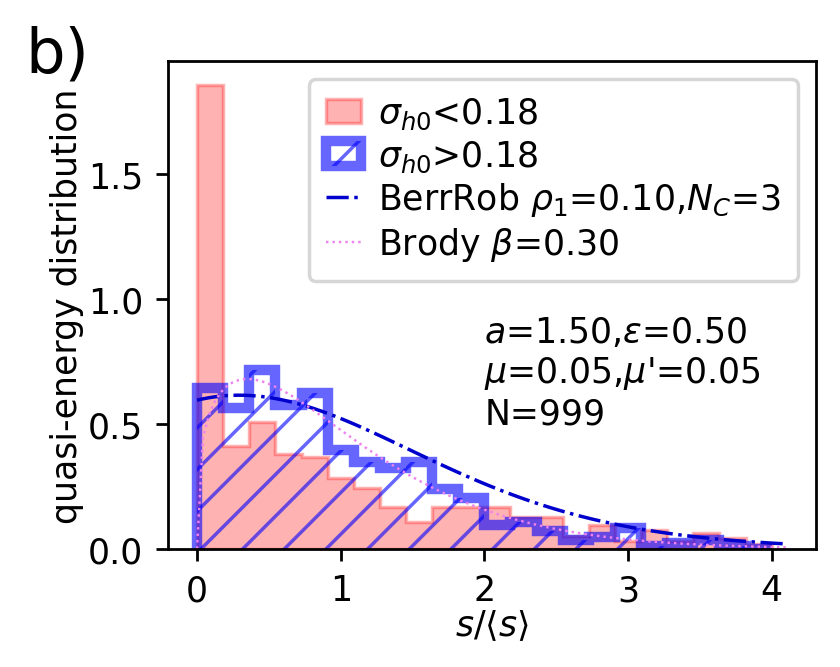

In [251]:
z=0.18
N_C_list  = np.array([3,1]); 
beta = 0.3
rho_1_list = np.array([0.1,beta])
type_list = ['BR','Brody']
comp_2histsb(sim4r,z,N_C_list,rho_1_list,type_list)  # make another nice figure!
